In [138]:
#compare to a base model
import pandas as pd
import numpy as np

In [139]:
#data
dataset = pd.read_csv('/home/kate/data/ClaimPrediction/fdata_v1_encd.csv', index_col=None)
target_column = 'hasclaim'

In [140]:
#models and analyzing results directory
ModelsDir='/home/kate/data/ClaimPrediction/t3_AllFeaturesInd/'

In [141]:
#comparing model metrics with t-test
#and save results
import scipy.stats as stats
def AnalyzeAndSaveModelsResults(result_df,result_lst,ModelName,filename):
    df=pd.DataFrame([result_lst])
    TestSizeColumns=['S0.45','S0.4','S0.35','S0.3','S0.25','S0.2','S0.15','S0.1']
    #TestSizeColumns=['S0.2','S0.15','S0.1']
    df.columns=['Model']+TestSizeColumns
    #mean
    df['Mean'] = df.drop('Model', axis=1).mean(axis=1)
    df['t-pvalue'] = 1
    df['t-statistic'] = 0
    df['Group'] = 1
    #t-test with base model
    if ModelName!='BaseModel':
        base_model=result_df[result_df['Model'] == 'BaseModel'].iloc[0]
        current_model=df.iloc[0]
        t=stats.ttest_ind(base_model[TestSizeColumns].tolist(),current_model[TestSizeColumns].tolist())
        line_to_save=[current_model['Model']]
        line_to_save.extend(current_model[TestSizeColumns].tolist())
        line_to_save.append(current_model[TestSizeColumns].mean())
        line_to_save.append(t.pvalue)
        line_to_save.append(t.statistic)
        if ((t.pvalue<=0.05) and (base_model['Mean']<current_model['Mean'])):
            line_to_save.append(2)
        elif ((t.pvalue<=0.05) and (base_model['Mean']>current_model['Mean'])):
            line_to_save.append(3)    
        else:
            line_to_save.append(1)                  
        df_to_save=pd.DataFrame([line_to_save])
        df_to_save.columns=['Model']+TestSizeColumns+['Mean','t-pvalue','t-statistic','Group']
        result_df=result_df.append(df_to_save, ignore_index=True)
    else:
        result_df=result_df.append(df, ignore_index=True)
    result_df.to_csv(ModelsDir+filename, index = False)
    return result_df

In [142]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))
def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  fmin_samples_leaf=1.0,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    fmin_samples_leaf (float) : minimum samples to take category average into account as a fraction of count
    KD: original min_samples_leaf = level count * fmin_samples_leaf
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    # 
    smoothing = 1 / (1 + np.exp(-(averages["count"] - averages["count"]*fmin_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [143]:
#xgb library and parameters to tune later
import xgboost as xgb
xgb_params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True}

In [144]:
#Evaluation metric to be used in tuning
from sklearn.metrics import roc_auc_score
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [145]:
#Random Undersampler to balance the dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
#ratio=0.918 to tune later

In [146]:
#StratifiedKFold
from sklearn.model_selection import StratifiedKFold
nrounds=5000 # need to change to 2000
kfold = 10  # need to change to 10
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [147]:
#splitting to train/test in the loop below
from sklearn.model_selection import train_test_split

In [148]:
#each line in the file contains the model name and set of features to analize
models = pd.read_csv(ModelsDir+'Models.csv', index_col=None)

In [149]:
print (len(models))

136


In [150]:
#summary for test and train metrics for each model to test overfitting
models_test_gini_df=pd.DataFrame()
models_test_roc_auc_df=pd.DataFrame()
#
models_train_gini_df=pd.DataFrame()
models_train_roc_auc_df=pd.DataFrame()
#
base_model_df=pd.DataFrame()

In [151]:
for index, row in models.iterrows():
    #for test and train metrics for each model to test overfitting
    gini_test_lst=[]
    roc_auc_test_lst=[]
    gini_train_lst=[]
    roc_auc_train_lst=[]
    #Starting analyzing metric
    print (index, ': Analyzing model %s'%row['Model'])
    #add model name to metric storage
    gini_test_lst.append(row['Model'])
    roc_auc_test_lst.append(row['Model'])
    gini_train_lst.append(row['Model'])
    roc_auc_train_lst.append(row['Model'])
    #getting model parameters
    #first element names of rows in a creating current row dataframe
    featureset=['feature']
    fmin_samples_leaf_set=['fmin_samples_leaf']
    smoothing_set=['smoothing']
    noise_level_set=['noise_level']
    for c in row.index:
        if 'fmin_samples_leaf' in c:
            fmin_samples_leaf_set.append(row[c])
        elif 'smoothing' in c:
            smoothing_set.append(row[c])
        elif 'noise_level' in c:
            noise_level_set.append(row[c])
        elif 'F' in c:
            featureset.append(row[c])
    featureset=[x for x in featureset if str(x) != 'nan']
    fmin_samples_leaf_set=[x for x in fmin_samples_leaf_set if str(x) != 'nan']
    smoothing_set=[x for x in smoothing_set if str(x) != 'nan']
    noise_level_set=[x for x in noise_level_set if str(x) != 'nan']
    #into a dataframe with index as names of rows: fmin_samples_leaf, smoothing, noise_level
    #and columns as feature names
    analyzed_model=pd.DataFrame([fmin_samples_leaf_set,smoothing_set,noise_level_set])
    analyzed_model.columns=featureset #first column is now names of rows
    analyzed_model.set_index('feature', inplace=True)
    print (analyzed_model)
    #calculating metrics for the current featureset and other parameters and 
    #several data sizes
    for s in (0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1):
    #for s in (0.2,0.15,0.1):
        print ('Test size %s'%s)
        X, X_test, y, y_test = train_test_split(dataset.loc[:,analyzed_model.columns], dataset[target_column], test_size=s, random_state=42)
        #prediction dataframes
        y_pred_test=pd.DataFrame(index=y_test.index)
        y_pred_test[target_column]=0
        #
        X_test_origin=X_test.copy(deep=True)
        #Stratified Fold
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
            #getting fold data
            X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
            y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
            #adding targeting encoding 
            #for each train, test and valid part currently analyzing model columns
            #if all parameters are not -1
            X_test=X_test_origin.copy(deep=True)
            for c in analyzed_model.columns:
                fmin_samples_leaf=analyzed_model[c]['fmin_samples_leaf']
                smoothing=analyzed_model[c]['smoothing']
                noise_level=analyzed_model[c]['noise_level']
                if (fmin_samples_leaf>-1.0 and smoothing>-1.0 and noise_level>-1.0):
                    print ('--------------TARGETING ENCODING---------------------------------------')
                    X_train[c.replace('_encd','')+ "_trgenc"], X_test[c.replace('_encd','')+"_trgenc"] = target_encode(
                                         trn_series=X_train[c],
                                         tst_series=X_test[c],
                                         target=y_train,
                                         fmin_samples_leaf=fmin_samples_leaf,
                                         smoothing=smoothing,
                                         noise_level=noise_level)
                    X_train[c.replace('_encd','')+ "_trgenc"], X_valid[c.replace('_encd','')+ "_trgenc"] = target_encode(
                                         trn_series=X_train[c],
                                         tst_series=X_valid[c],
                                         target=y_train,
                                         fmin_samples_leaf=fmin_samples_leaf,
                                         smoothing=smoothing,
                                         noise_level=noise_level)
                    X_train.drop(c, axis=1, inplace=True)
                    X_valid.drop(c, axis=1, inplace=True)
                    X_test.drop(c, axis=1, inplace=True)
            #
            X_train = X_train.values
            X_valid = X_valid.values
            #
            y_pred_train=pd.DataFrame(index=y_train.index)
            y_pred_train[target_column]=0
            #
            y_train = y_train.values
            y_valid = y_valid.values
            #balancing dataset
            X_res, y_res = rus.fit_sample(X_train, y_train)
            #applying XGB
            d_train = xgb.DMatrix(X_res, y_res) 
            d_valid = xgb.DMatrix(X_valid, y_valid) 
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            xgb_model = xgb.train(xgb_params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=1000)
            y_pred_test[target_column] +=  xgb_model.predict(xgb.DMatrix(X_test.values), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
            y_pred_train[target_column] += xgb_model.predict(xgb.DMatrix(X_train), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
        #Prediction results
        #test
        g=gini(y_test,y_pred_test)/gini(y_test,y_test)
        print('Test Gini - %f'%g)
        gini_test_lst.append(g)
        ROC_AUC=roc_auc_score(y_test, y_pred_test)
        print('Test ROC_AUC - %f'%ROC_AUC)
        roc_auc_test_lst.append(ROC_AUC)
        #train
        g=gini(y_train,y_pred_train)/gini(y_train,y_train)
        print('Train Gini - %f'%g)
        gini_train_lst.append(g)
        ROC_AUC=roc_auc_score(y_train, y_pred_train)
        print('Train ROC_AUC - %f'%ROC_AUC)
        roc_auc_train_lst.append(ROC_AUC)
    #save model analysis results
    models_test_gini_df=AnalyzeAndSaveModelsResults(models_test_gini_df,gini_test_lst,row['Model'],'models_test_gini.csv')
    models_test_roc_auc_df=AnalyzeAndSaveModelsResults(models_test_roc_auc_df,roc_auc_test_lst,row['Model'],'models_test_roc_auc.csv')
    models_train_gini_df=AnalyzeAndSaveModelsResults(models_train_gini_df,gini_train_lst,row['Model'],'models_train_gini.csv')
    models_train_roc_auc_df=AnalyzeAndSaveModelsResults(models_train_roc_auc_df,roc_auc_train_lst,row['Model'],'models_train_roc_auc.csv')

0 : Analyzing model BaseModel
                   driverage  vehicleage  mvrstatusage
feature                                               
fmin_samples_leaf         -1          -1            -1
smoothing                 -1          -1            -1
noise_level               -1          -1            -1
Test size 0.45
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.58632	valid-auc:0.556575	train-gini:-0.101985	valid-gini:0.112821
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[14]	train-auc:0.629382	valid-auc:0.598938	train-gini:0.241149	valid-gini:0.197957

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.58304	valid-auc:0.604693	train-gini:-0.172698	valid-gini:0.186235
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[81]	train-auc:0.632361	valid-auc:0.64

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[162]	train-auc:0.633855	valid-auc:0.601952	train-gini:0.266752	valid-gini:0.203801

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.574583	valid-auc:0.590746	train-gini:-0.035415	valid-gini:0.151719
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[56]	train-auc:0.626116	valid-auc:0.627737	train-gini:0.244498	valid-gini:0.254237

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.580479	valid-auc:0.569214	train-gini:0.00767	valid-gini:0.110182
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[255]	train-auc:0.636554	valid-auc:0.624491	train-gini:0.272681	valid-gini:0.248918

 xgb kfold: 5  o

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[5]	train-auc:0.619806	valid-auc:0.626984	train-gini:0.214568	valid-gini:0.254652

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.57048	valid-auc:0.567625	train-gini:-0.052298	valid-gini:0.125814
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[231]	train-auc:0.635286	valid-auc:0.6305	train-gini:0.269956	valid-gini:0.260977

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.56966	valid-auc:0.563197	train-gini:-0.036154	valid-gini:0.129639
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[6]	train-auc:0.622353	valid-auc:0.595865	train-gini:0.225482	valid-gini:0.191849

 xgb kfold: 7  of  10

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[416]	train-auc:0.638485	valid-auc:0.625234	train-gini:0.276609	valid-gini:0.25042

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.576225	valid-auc:0.557293	train-gini:-0.089755	valid-gini:0.113199
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[38]	train-auc:0.628398	valid-auc:0.600052	train-gini:0.242791	valid-gini:0.200167

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.575607	valid-auc:0.55742	train-gini:-0.10535	valid-gini:0.118846
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[58]	train-auc:0.626145	valid-auc:0.6112	train-gini:0.236796	valid-gini:0.22315

 xgb kfold: 9  of  10

Stopping. Best iteration:
[32]	train-auc:0.667707	valid-auc:0.634871	train-gini:0.318236	valid-gini:0.271783

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.624516	valid-auc:0.622621	train-gini:0.10089	valid-gini:0.25994
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[29]	train-auc:0.665957	valid-auc:0.646095	train-gini:0.323621	valid-gini:0.292846

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.629237	valid-auc:0.583594	train-gini:0.095311	valid-gini:0.192756
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[3]	train-auc:0.65579	valid-auc:0.596671	train-gini:0.257371	valid-gini:0.20052

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.624	valid-auc:0.59519	train-gini:0.092794	valid-gini:0.213478
Multiple eval metrics have been passed: 'valid-gini' will be used 

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.623556	valid-auc:0.584721	train-gini:0.0722	valid-gini:0.184596
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[137]	train-auc:0.671485	valid-auc:0.622	train-gini:0.340997	valid-gini:0.244412

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.621557	valid-auc:0.593773	train-gini:0.066724	valid-gini:0.203379
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[152]	train-auc:0.671144	valid-auc:0.644163	train-gini:0.341205	valid-gini:0.288418

Test Gini - 0.295613
Test ROC_AUC - 0.647808
Train Gini - 0.314080
Train ROC_AUC - 0.657046
Test size 0.3
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.604306	valid-auc:0.602418	train-gini:-0.018734	valid-gini:0.208603
Multiple eval metrics have been passed: 'valid-gini' will be u

Test Gini - 0.292289
Test ROC_AUC - 0.646143
Train Gini - 0.310049
Train ROC_AUC - 0.655035
Test size 0.2
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.608055	valid-auc:0.588584	train-gini:-0.01716	valid-gini:0.180193
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[62]	train-auc:0.662082	valid-auc:0.647768	train-gini:0.318451	valid-gini:0.295652

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.602319	valid-auc:0.587501	train-gini:-0.049714	valid-gini:0.225345
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[29]	train-auc:0.658471	valid-auc:0.646545	train-gini:0.292543	valid-gini:0.29774

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.607238	valid-auc:0.589764	train-gini:-0.028426	valid-gini:0.210458
Multiple eval metrics have been passed: 'valid-gini' will be

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.62509	valid-auc:0.601875	train-gini:0.096668	valid-gini:0.215106
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[316]	train-auc:0.670641	valid-auc:0.645029	train-gini:0.341041	valid-gini:0.290062

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.622765	valid-auc:0.61349	train-gini:0.108316	valid-gini:0.228665
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[35]	train-auc:0.657653	valid-auc:0.638837	train-gini:0.297309	valid-gini:0.278715

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.623125	valid-auc:0.633188	train-gini:0.108687	valid-gini:0.256771
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterati

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[313]	train-auc:0.681966	valid-auc:0.649835	train-gini:0.363671	valid-gini:0.299642

 xgb kfold: 2  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.621759	valid-auc:0.64001	train-gini:0.06471	valid-gini:0.261271
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[81]	train-auc:0.665036	valid-auc:0.66196	train-gini:0.327663	valid-gini:0.323654

 xgb kfold: 3  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.622516	valid-auc:0.634479	train-gini:0.089427	valid-gini:0.237654
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved i

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[133]	train-auc:0.670631	valid-auc:0.644316	train-gini:0.33971	valid-gini:0.28877

Test Gini - 0.295399
Test ROC_AUC - 0.647701
Train Gini - 0.313525
Train ROC_AUC - 0.656766
Test size 0.3
 xgb kfold: 1  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.604306	valid-auc:0.602418	train-gini:-0.018734	valid-gini:0.208603
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[327]	train-auc:0.672272	valid-auc:0.655127	train-gini:0.344322	valid-gini:0.310261

 xgb kfold: 2  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.605785	valid-auc:0.589703	train-gini:-0.011951	valid-gini:0.171903
Multiple eval metrics 

 xgb kfold: 9  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.625911	valid-auc:0.592166	train-gini:0.09576	valid-gini:0.206505
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[10]	train-auc:0.663648	valid-auc:0.61914	train-gini:0.307984	valid-gini:0.241221

 xgb kfold: 10  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.626191	valid-auc:0.579649	train-gini:0.101073	valid-gini:0.178527
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[56]	train-auc:0.667817	valid-auc:0.641109	train-gini:0.330235	valid-gini:0.282606

Test Gini - 0.292285
Test ROC_AUC - 0.646141
Train Gini - 0.310049
Train ROC_AUC - 0.655035
Test size 0.2
 xgb kfold: 1  of  10 : 


Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[170]	train-auc:0.671663	valid-auc:0.645368	train-gini:0.342412	valid-gini:0.290762

 xgb kfold: 8  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.622537	valid-auc:0.60633	train-gini:0.057456	valid-gini:0.228425
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[29]	train-auc:0.660345	valid-auc:0.635445	train-gini:0.303268	valid-gini:0.272517

 xgb kfold: 9  of  10 : 
--------------TARGETING ENCODING---------------------------------------
[0]	train-auc:0.620453	valid-auc:0.59118	train-gini:0.053688	valid-gini:0.19972
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved i

Red and Green bars below indicates models where mean of gini is likely different from a previous model

In [152]:
models_test_gini_df

,Model,S0.45,S0.4,S0.35,S0.3,S0.25,S0.2,S0.15,S0.1,Mean,t-pvalue,t-statistic,Group
0,BaseModel,0.221477,0.215657,0.216327,0.211724,0.211135,0.213257,0.214288,0.210966,0.214354,1.000000e+00,0.000000,1
1,accidentpreventioncourseind,0.290863,0.293979,0.295613,0.294827,0.292289,0.301710,0.287023,0.298916,0.294402,1.023541e-15,-39.213421,2
2,accidentpreventioncourseind_0,0.290984,0.293847,0.295399,0.294295,0.292285,0.301705,0.286876,0.298953,0.294293,1.074775e-15,-39.075687,2


In [153]:
models_test_gini_df.set_index('Model', inplace=True)

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
colors = {1: 'blue', 2: 'green',3: 'red'}

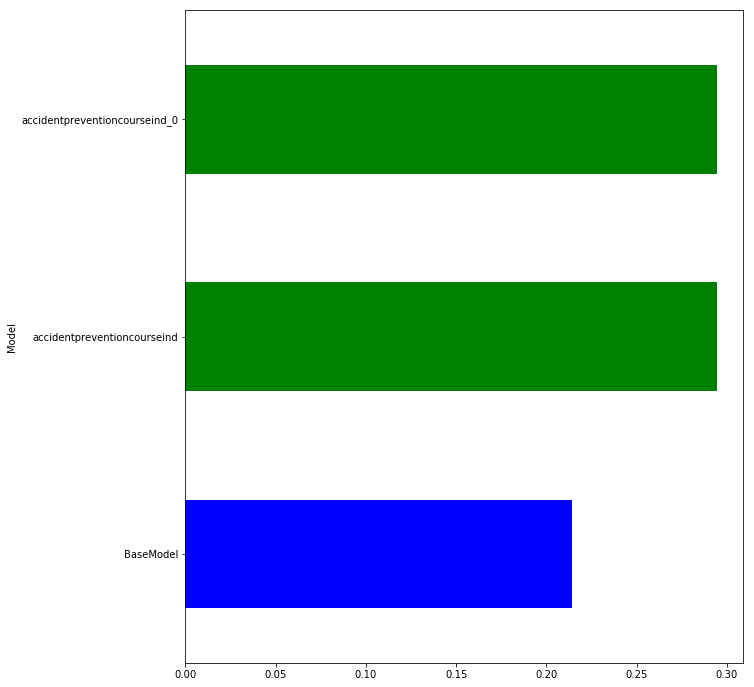

In [156]:
customcmap = tuple(models_test_gini_df['Group'].map(colors))
models_test_gini_df['Mean'].plot(kind='barh',  color=[customcmap], figsize=(10, 12))